In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import numpy as np
from torch.utils.data import Dataset, DataLoader
from typing import List, Tuple, Dict
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from fedot.core.pipelines.tuning.search_space import PipelineSearchSpace


In [2]:
pl.seed_everything(12345)

Seed set to 12345


12345

In [3]:
class NodeDataset(Dataset):
    def __init__(self, operations: List[str], length: int = int(1e5), missing_rate=1e-2) -> None:
        super().__init__()
        self.operations = operations
        self.length = length
        self.missing_rate = missing_rate
        self.search_space = PipelineSearchSpace().get_parameters_dict()
    
    def get_nodes_dimensions(self) -> Dict[str, int]:
        return {op_name: len(self.search_space[op_name]) if op_name in self.search_space else 0 for op_name in self.operations}
    
    def generate(self) -> Dict[str, torch.Tensor]:
        sample = {}
        for op_name in self.operations:
            if op_name in self.search_space:
                config = self.search_space[op_name]
                parameters_vector = []
                for param_name, param_config in config.items():
                    parameter_type = param_config["type"]
                    sampling_scope = param_config["sampling-scope"]
                    if np.random.rand() < self.missing_rate:  # Emulate missing value.
                        parameter_value = -1
                    else:
                        if parameter_type == "categorical":  # Do Ordinal encoding.
                            parameter_value = np.random.randint(0, len(sampling_scope[0]), 1).item()
                        else:  # Do Min-Max scaling.
                            parameter_value = np.random.uniform(*sampling_scope, 1).item()
                            lower_bound = sampling_scope[0]
                            upper_bound = sampling_scope[1]
                            parameter_value = (parameter_value - lower_bound) / (upper_bound - lower_bound)
                    parameters_vector.append(parameter_value)
                sample[op_name] = torch.Tensor(parameters_vector)
            else:
                sample[op_name] = torch.Tensor([])
        return sample
    
    def __len__(self):
        return self.length
    
    def __getitem__(self, *args, **kwargs) ->  Dict[str, torch.Tensor]:
        return self.generate()

In [4]:
class Encoder(nn.Module):
    def __init__(self, n_input: int, n_hidden: List[int], n_output: int):
        super().__init__()
        assert len(n_hidden) > 0
        self.model = nn.Sequential()
        self.model.append(nn.Linear(n_input, n_hidden[0]))
        self.model.append(nn.ReLU())
        for i in range(1, len(n_hidden)):
             self.model.append(nn.Linear(n_hidden[i-1], n_hidden[i]))
             self.model.append(nn.ReLU())
        self.model.append(nn.Linear(n_hidden[-1], n_output))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

class Decoder(nn.Module):
    def __init__(self, n_input: int, n_hidden: List[int], n_output: int):
        super().__init__()
        assert len(n_hidden) > 0
        self.model = nn.Sequential()
        self.model.append(nn.Linear(n_input, n_hidden[0]))
        self.model.append(nn.ReLU())
        for i in range(1, len(n_hidden)):
             self.model.append(nn.Linear(n_hidden[i-1], n_hidden[i]))
             self.model.append(nn.ReLU())
        self.model.append(nn.Linear(n_hidden[-1], n_output))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

class AutoEncoder(nn.Module):
    def __init__(self, n_input, n_hidden: List[int], n_embedding: int=8):
        super().__init__()
        self.encoder = Encoder(n_input, n_hidden, n_embedding)
        self.decoder = Decoder(n_embedding, n_hidden, n_input)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        embedding = self.encoder(x)
        reconstruction = self.decoder(embedding)
        return embedding, reconstruction

In [5]:
class JoinedAutoEncoders(pl.LightningModule):
    def __init__(self, autoencoders: Dict[str, nn.Module], learnable: Dict[str, nn.Parameter] = None):
        super().__init__()
        self.autoencoders = nn.ModuleDict(autoencoders)
        
        self.learnable = nn.ParameterDict()
        if learnable is not None:
            self.learnable = nn.ParameterDict(learnable)
    
    def reconstruction_loss(self, pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        loss = F.mse_loss(pred, target)
        return loss
    
    def embedding_simmilarity_loss(self, embeddings: List[torch.Tensor]) -> torch.Tensor:
        losses = []
        for i in range(len(embeddings)):
            anchor = embeddings[i]
            shuffled_indices = np.arange(len(anchor))
            np.random.shuffle(shuffled_indices)
            positives = anchor[shuffled_indices]
            for j in range(len(embeddings)):
                if j != i:
                    negatives = embeddings[j]
                    losses.append(F.triplet_margin_loss(anchor, positives, negatives))
        loss = torch.mean(torch.stack(losses))
        return loss 

    def training_step(self, x: Dict[str, torch.Tensor], *args, **kwargs) -> torch.Tensor:
        batch_size = x[list(x.keys())[0]].shape[0]
        
        embeddings = []
        reconstruction_losses = []
        for key in x:
            if key in self.autoencoders:
                data = x[key]
                embedding, reconstruction = self.autoencoders[key](data)
                reconstruction_losses.append(self.reconstruction_loss(reconstruction, data))
                embeddings.append(embedding)
            elif key in self.learnable:
                embeddings.append(self.learnable[key].repeat(batch_size, 1))
        reconstruction_loss = torch.mean(torch.stack(reconstruction_losses))
        embedding_simmilarity_loss = self.embedding_simmilarity_loss(embeddings)
        loss = reconstruction_loss + embedding_simmilarity_loss
        self.log("train/reconstruction_loss", reconstruction_loss)
        self.log("train/embedding_simmilarity_loss", embedding_simmilarity_loss)
        self.log("train/loss", loss)
        return loss
    
    def validation_step(self, x: Dict[str, torch.Tensor], *args, **kwargs):
        with torch.no_grad():
            reconstruction_losses = []
            for key in x:
                if key in self.autoencoders:
                    data = x[key]
                    _, reconstruction = self.autoencoders[key](data)
                    reconstruction_losses.append(self.reconstruction_loss(reconstruction, data))
        reconstruction_loss = torch.mean(torch.stack(reconstruction_losses))
        self.log("val/reconstruction_loss", reconstruction_loss)

    def configure_optimizers(self) -> optim.Optimizer:
            optimizer = optim.AdamW(self.parameters(), lr=1e-3, weight_decay=1e-5)
            return optimizer

In [6]:
operations = [
 'bernb',
 'dt',
 'fast_ica',
 'isolation_forest_class',
 'knn',
 'lgbm',
 'logit',
 'mlp',
 'normalization',
 'pca',
 'poly_features',
 'qda',
 'resample',
 'rf',
 'scaling',
]

train_ds = NodeDataset(operations)
val_ds = NodeDataset(operations)

nodes_dimensions = train_ds.get_nodes_dimensions()
print(max(list(nodes_dimensions.values())))

7


In [7]:
operations_with_hyperparams = [
 'dt',
 'fast_ica',
 'isolation_forest_class',
 'knn',
 'lgbm',
 'logit',
 'pca',
 'poly_features',
 'resample',
 'rf',
]
operations_without_hyperparams = list(filter(lambda x: x not in operations_with_hyperparams, operations))

In [8]:
BATCH_SIZE = 1024
MAX_EPOCHS = 10

N_EMBEDDING = 8  # TODO: need several experiments
N_HIDDEN = [8,8]
autoencoders = {}
for key in operations_with_hyperparams:
    n_input = nodes_dimensions[key]
    autoencoder = AutoEncoder(n_input, N_HIDDEN, N_EMBEDDING)
    autoencoders[key] = autoencoder
learnable = {}
for key in operations_without_hyperparams:
    learnable[key] = nn.Parameter(data=torch.rand(N_EMBEDDING), requires_grad=True)

model = JoinedAutoEncoders(autoencoders, learnable)

train_dl = DataLoader(train_ds, BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_ds, BATCH_SIZE, shuffle=False)

logger = TensorBoardLogger("/Users/cherniak/itmo_job/GAMLET/experiment_logs")
early_stopping_callback = EarlyStopping("val/reconstruction_loss")
model_checkpoint_callback = ModelCheckpoint()
trainer = pl.Trainer(
    max_epochs=MAX_EPOCHS,
    logger=logger,
    callbacks=[early_stopping_callback, model_checkpoint_callback]
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [9]:
trainer.fit(model, train_dl, val_dl)


  | Name         | Type          | Params
-----------------------------------------------
0 | autoencoders | ModuleDict    | 3.5 K 
1 | learnable    | ParameterDict | 40    
-----------------------------------------------
3.5 K     Trainable params
0         Non-trainable params
3.5 K     Total params
0.014     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/cherniak/anaconda3/envs/gamlet/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


/Users/cherniak/anaconda3/envs/gamlet/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 98/98 [00:49<00:00,  2.00it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 98/98 [00:49<00:00,  2.00it/s, v_num=0]


In [17]:
base_path = "/Users/cherniak/itmo_job/GAMLET/experiment_logs/lightning_logs"
name = "to_8_with_learnables"
ckpt_name = "epoch=9-step=980"
ckpt = torch.load(f"{base_path}/{name}/checkpoints/{ckpt_name}.ckpt")

In [18]:
model.load_state_dict(ckpt["state_dict"], strict=False)

<All keys matched successfully>

In [19]:
sample = next(iter(val_dl))
sample = {k: v.to(model.device) for k, v in sample.items()}

In [20]:
embeddings = {}
reconstructions = {}

with torch.no_grad():
    for key in sample:
        data = sample[key]
        if key in model.autoencoders:
            embedding, reconstruction = model.autoencoders[key](data)
            embeddings[key] = embedding
            reconstructions[key] = reconstruction
        elif key in model.learnable:
            batch_size = data.shape[0]
            embeddings[key] = model.learnable[key].repeat(batch_size, 1)
        else:
            print(f"Unknown key: {key}")

In [21]:
for k in reconstructions:
    print(k, " | ", sample[k][0], "->", reconstructions[k][0])
    print()

dt  |  tensor([0.0712, 0.9764, 0.2411]) -> tensor([0.3582, 0.6051, 0.0851])

fast_ica  |  tensor([0.2667, 2.0000]) -> tensor([0.2646, 2.0028])

isolation_forest_class  |  tensor([0.1709, 0.1095, 0.0000]) -> tensor([0.2110, 0.0665, 0.0168])

knn  |  tensor([0.6283, 0.0000, 0.0000]) -> tensor([ 0.6218,  0.0051, -0.0021])

lgbm  |  tensor([1.0000, 0.4219, 0.8078, 0.4813, 0.0888, 0.2270, 0.0775]) -> tensor([1.0092, 0.3021, 0.4797, 0.2362, 0.2571, 0.3737, 0.3458])

logit  |  tensor([0.8399]) -> tensor([0.8426])

pca  |  tensor([0.1311]) -> tensor([0.1302])

poly_features  |  tensor([0.8859, 1.0000]) -> tensor([0.9012, 0.9904])

resample  |  tensor([0.0000, 1.0000, 0.9163]) -> tensor([0.0127, 0.9819, 0.8622])

rf  |  tensor([ 0.0000,  0.0241, -1.0000,  0.1849,  0.0000]) -> tensor([ 0.1403,  0.3310,  0.3720,  0.1086, -0.0718])



In [22]:
transformed = TSNE(2, init="pca").fit_transform(torch.vstack(list(embeddings.values())).cpu())

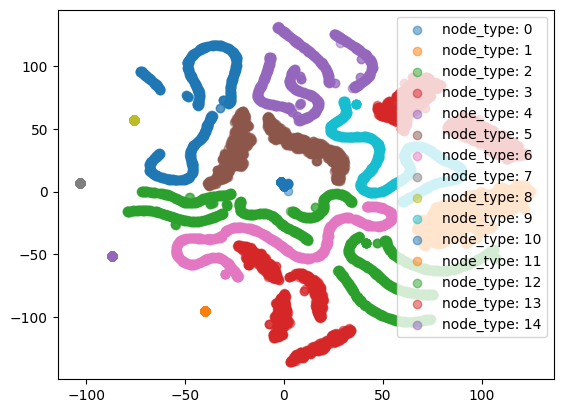

In [23]:
for i, e in enumerate(transformed.reshape(len(embeddings), -1, 2)):
    plt.scatter(*e.T, alpha=0.5, label=f"node_type: {i}")
plt.legend()